twobox_tvaryOH for Lab 2 of EESCGR6926 Fall 2019 (9/25/19)


In [308]:
import scipy.integrate as spint
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
#NEEDED TO READ IN DATA FROM A TEXT FILE (CSV)
import pandas as pd
#NEEDED TO UPLOAD A FILE INTO COLAB PLATFORM
# from google.colab import files
import pandas as pd
import seaborn as sns
import xarray as xr

Loading the a datasets for CH4 Antropogenic Emissions, Wetland Emissions, and OH concentrations from GFDL model.

In [355]:
mwch4=.016
mwoh =.017
mwair=.029
mass_atm=5.2e9 * 0.9

# ch4_emission = xr.open_dataset('ch4_antropogenic_emissions_zonal_model_mean.nc').ch4_antro * 1e-9 * 12 *1e3 #/ (30*24*60*60)
# wet_emission = xr.open_dataset('wetland_emissions_zonal_model_mean.nc').wetland_emissions / 1e6 * 1e-9 * 1e3 * 12 #/ (30*24*60*60)
# oh = xr.open_dataset('OH_concentration_zonal_mean.nc').OH.mean('p') * mwair/mwch4 / mass_atm / (30*24*60*60*12) *1e2

# ch4_emission = xr.open_dataset('ch4_antropogenic_emissions_zonal_model_mean.nc').ch4_antro * mwair/mwch4 *1e3 / (30) *1e-9
# wet_emission = xr.open_dataset('wetland_emissions_zonal_model_mean.nc').wetland_emissions * 1e-3 * mwair/mwch4 / (30)*1e-9
# oh = xr.open_dataset('OH_concentration_zonal_mean.nc').OH.mean('p') * mwair/mwoh * 1e-9 / (30*24*60*60)

ch4_emission = xr.open_dataset('ch4_antropogenic_emissions_zonal_model_mean.nc').ch4_antro * 1e-6 * 12 / 2
wet_emission = xr.open_dataset('wetland_emissions_zonal_model_mean.nc').wetland_emissions * 1e-12 * 12 / 2
# oh = xr.open_dataset('OH_concentration_zonal_mean.nc').OH.mean('p') * 1e-3 * 1e-9 * 12# / (30*24*60*60) #* mwair/(mwch4 * mass_atm * 30*24*60*60 * 1e3)
oh = xr.open_dataset('OH_concentration_zonal_mean.nc').OH.sum('p') * 1e-9  / (30*24*60*60) / 2 #* mwair/(mwch4 * mass_atm * 30*24*60*60 * 1e3)


Taking monthly means of last 5 years available for all data and split them into NH and SH.

In [360]:
ch4_nh = ch4_emission.sel(time = slice('1/2010','1/2015'), lat = slice(0,90)).\
    sum('lat').groupby('time.month').mean('time').interp(month=np.arange(1,12.01,0.1))
ch4_sh = ch4_emission.sel(time = slice('1/2010','1/2015'), lat = slice(-90,0)).\
    sum('lat').groupby('time.month').mean('time').interp(month=np.arange(1,12.01,0.1))
ch4_global = ch4_emission.sel(time = slice('1/2010','1/2015')).\
    sum('lat').groupby('time.month').mean('time').interp(month=np.arange(1,12.01,0.1))

wet_nh = wet_emission.sel(time = slice('1/2010','1/2015'), lat = slice(0,90)).\
    sum('lat').groupby('time.month').mean('time').interp(month=np.arange(1,12.01,0.1))
wet_sh = wet_emission.sel(time = slice('1/2010','1/2015'), lat = slice(-90,0)).\
    sum('lat').groupby('time.month').mean('time').interp(month=np.arange(1,12.01,0.1))
wet_global = wet_emission.sel(time = slice('1/2010','1/2015')).\
    sum('lat').groupby('time.month').mean('time').interp(month=np.arange(1,12.01,0.1))

oh_nh = oh.sel(lat = slice(0,90)).sum('lat').interp(month=np.arange(1,12.01,0.1)) /\
            (oh.sel(lat = slice(0,90)).sum('lat').interp(month=np.arange(1,12.01,0.1))).mean()
oh_sh = oh.sel(lat = slice(-90,0)).sum('lat').interp(month=np.arange(1,12.01,0.1)) /\
            (oh.sel(lat = slice(-90,0)).sum('lat').interp(month=np.arange(1,12.01,0.1))).mean()
oh_global = oh.sum('lat').interp(month=np.arange(1,12.01,0.1)) /\
            (oh.sum('lat').interp(month=np.arange(1,12.01,0.1))).mean()

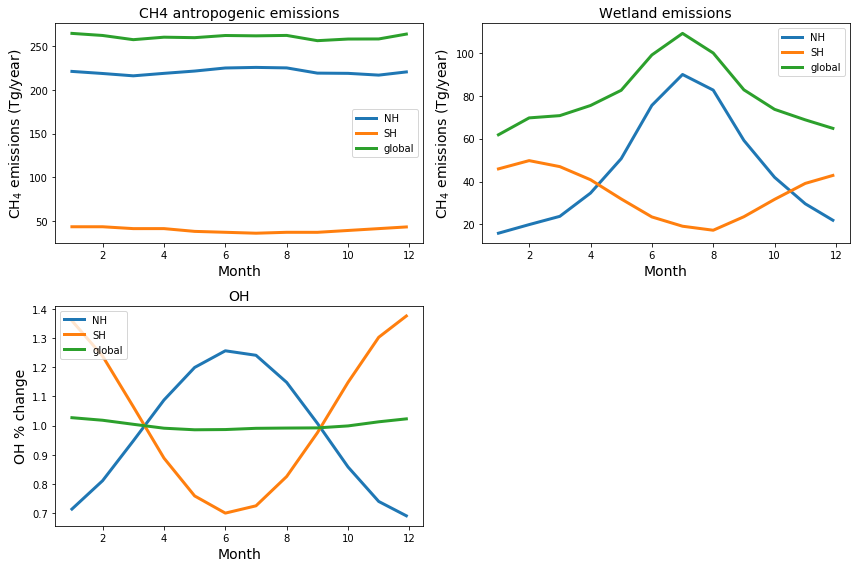

In [406]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

ax = fig.add_subplot(2,2,1)
ch4_nh.plot(label = 'NH',linewidth=3)
ch4_sh.plot(label = 'SH',linewidth=3)
ch4_global.plot(label = 'global',linewidth=3)
plt.ylabel('CH$_4$ emissions (Tg/year)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title('CH4 antropogenic emissions', fontsize=14)
plt.tight_layout()

ax = fig.add_subplot(2,2,2)
wet_nh.plot(label = 'NH',linewidth=3)
wet_sh.plot(label = 'SH',linewidth=3)
wet_global.plot(label = 'global',linewidth=3)
plt.ylabel('CH$_4$ emissions (Tg/year)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title('Wetland emissions', fontsize=14)

ax = fig.add_subplot(2,2,3)
oh_nh.plot(label = 'NH',linewidth=3)
oh_sh.plot(label = 'SH',linewidth=3)
oh_global.plot(label = 'global',linewidth=3)
plt.ylabel('OH % change', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title('OH', fontsize=14)

plt.tight_layout()
plt.savefig('figures/data_used.pdf')

## 1-box model

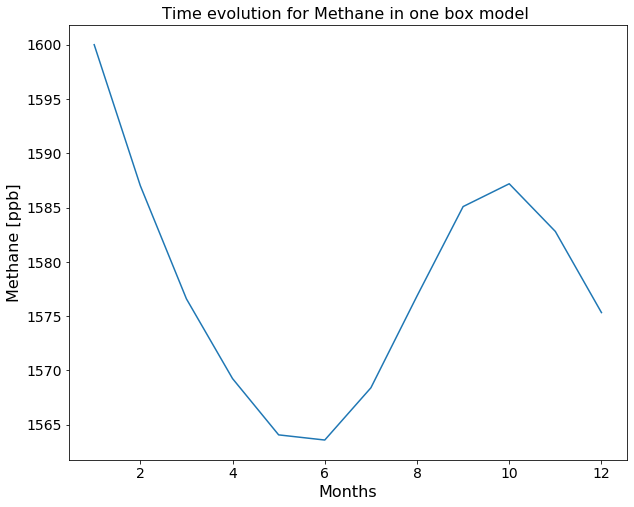

In [392]:
class onebox():
    """ one box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.e2, removal_rate=1e0, k = 0.085,
                        conc_ini=1600, time_ini=0, run_duration=13, time_offset=1,tstep=1):
        """ time integration of the one box equation
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        removal_rate: float
            Total removal rate of the chemical species from the atmosphere in 1/year 
        conc_ini: float
            initial concentration of chemical species in ppb
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.k = k
        self.emis = ch4_global + wet_global
        self.removal_rate = removal_rate
        self.mass_ini = np.array([conc_ini*self.conv])
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        # integrate the box equation with RK45
        solver = spint.solve_ivp(self.methane_onebox_mass_equations, (self.time_ini, self.time_end,),
                         self.mass_ini, method='RK45', t_eval=self.tstep)
        
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/self.conv
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb)
        plt.xlabel('Months',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in one box model ', fontsize=16)
        return None
        
    def methane_onebox_mass_equations(self, time, mass):
        """ governing equation """
        E = np.array((ch4_global+wet_global).sel(month = time, method = 'nearest'))
        removal_rate = np.array(oh_global.sel(month = time, method = 'nearest'))  #* 0.325e-1 * 0.395
#         print(E)
#         k = 0.085
        dmdt =  E -  self.k*(removal_rate * mass )
        return dmdt
boxmodel = onebox()
t, conc_ch4 = boxmodel.integrate_tracer(k=0.085)

array([1600.        , 1587.01546237, 1576.5902438 , 1569.24533379,
       1564.06045933, 1563.58545825, 1568.39560038, 1576.84938009,
       1585.08851627, 1587.18916669, 1582.79775212, 1575.32514632])

# 2-box model

In [66]:
class twobox_tvaryoh():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.2e2, nhemisfrac=0.75, nhOH=0., ohperiod=1., ohamp=.15, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1576., concSH_ini=1521., time_ini=0, run_duration=12, time_offset=0,tstep=1):
        """ time integration of the two box equation`
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        nhOH: float
            Percentage by which to increase the loss rate (due to differences in OH) in NH and decrease in SH
        ohperiod: float
            Period for OH oscillation in years
        ohamp: float
            Amplitude of OH oscillation as percentage
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.emis = emis
        self.emisNH = ch4_nh + wet_nh
        self.emisSH = ch4_sh + wet_sh
        self.tauNS = tauNS
        #self.ohperiod = ohperiod
        #self.ohamp = ohamp
        #print('CHEM_LOSS=',chem_loss)
        self.chem_lossNH = oh_nh
        self.chem_lossSH = oh_sh
        #print('N, S, AVGNS = ',self.chem_lossNH, self.chem_lossSH, ((self.chem_lossNH+self.chem_lossSH)/2.))
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini *(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),\
                                 self.mass_ini, method='RK45', vectorized='True')
                                   # t_eval=self.tstep - as set by Arlene
     
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='blue', label='NH')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='red', label='SH')
        plt.plot(self.time+self.time_offset, (self.tracer_ppb[0]+self.tracer_ppb[1])/2, color='black', label='global')
        plt.xlabel('monhts',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        plt.legend(loc=0)
        return None
        
    def methane_twobox_equations(self, time, mass):
        """ governing equation """ 
        
        #print(self.chem_lossNH[time])
        #convert period of oscillation into frequency
        #omega = 2*np.pi/self.ohperiod
        #print(time)
        #calculate OH loss for this time step; note the magnitude of the oscillation is set by ohamp
        #for now vary same way in both hemispheres
#         vary_oh_lossNH = np.array(self.chem_lossNH.sel(month = time, method='nearest'))# + self.ohamp*(self.chem_lossNH)*math.sin(omega*time)
#         vary_oh_lossSH = np.array(self.chem_lossSH.sel(month = time, method='nearest'))# + self.ohamp*(self.chem_lossSH)*math.sin(omega*time)
        vary_oh_lossNH = np.array(ch4_nh.sel(month = time, method='nearest') + 
                                  wet_nh.sel(month = time, method='nearest'))
        vary_oh_lossSH = np.array(ch4_sh.sel(month = time, method='nearest') + 
                                  wet_sh.sel(month = time, method='nearest'))
        
#         print(mass[0])
        dMnhdt = np.array(self.emisNH.sel(month = time, method='nearest'))  - ( vary_oh_lossNH * mass[0] ) +((mass[1]-mass[0])/self.tauNS)
        dMshdt = np.array(self.emisSH.sel(month = time, method='nearest'))  - ( vary_oh_lossSH * mass[1] ) +((mass[0]-mass[1])/self.tauNS)
        return np.array([dMnhdt, dMshdt])
boxmodel = twobox_tvaryoh()


t, conc_ch4 = boxmodel.integrate_tracer()

KeyboardInterrupt: 

In [23]:
conc_ini = 1576

conv = mass_atm*1e-9*mwch4/mwair
mass_ini = conc_ini*(conv/2.)

In [24]:
mass_ini

2034.6703448275864

# All below this line is Unedited Code from Lab

### Previous MEM2 model 

In [ ]:
class twobox():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5e2, nhemisfrac=0.75, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1576., concSH_ini=1521., time_ini=0, run_duration=3.5e1, time_offset=1980,tstep=1):
        """ time integration of the two box equation
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.emis = emis
        self.emisNH = emis*nhemisfrac
        self.emisSH = emis*(1-nhemisfrac)
        self.chem_loss = chem_loss
        self.tauNS = tauNS
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini*(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),
                                 self.mass_ini, method='RK45', t_eval=self.tstep, vectorized='True')
   
     
        self.time = solver['t']
        print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='red')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='blue')
        plt.xlabel('years',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        return None
        
    def methane_twobox_equations(self, time, mass):
        """ governing equation """ 
        if time < 20:
            dMnhdt = self.emisNH * 1.003 ** (time - self.time_ini) - ( self.chem_loss * mass[0] ) +((mass[1]-mass[0])/self.tauNS)
            dMshdt = self.emisSH * 1.003 ** (time - self.time_ini) - ( self.chem_loss * mass[1] ) +((mass[0]-mass[1])/self.tauNS)
#             print(1.03 ** (time - self.time_ini), time)
        if time >= 20:
            dMnhdt = self.emisNH * 1.003 ** (15) - ( self.chem_loss * mass[0] ) +((mass[1]-mass[0])/self.tauNS)
            dMshdt = self.emisSH * 1.003 ** (15) - ( self.chem_loss * mass[1] ) +((mass[0]-mass[1])/self.tauNS)
        return np.array([dMnhdt, dMshdt])
boxmodel = twobox()



t, conc_ch4 = boxmodel.integrate_tracer()
#store these results for use later.
# m0_years = t
# m0_ch4 = conc_ch4 # the conc_ch4[0] is NH and conc_ch4[1] is SH
# m0_ch4 = conc_ch4 # the conc_ch4[0] is NH and conc_ch4[1] is SH

ch4_MEM2_time = t
ch4_MEM2 = conc_ch4
#coding note: could alternatively just call boxmodel.integrate_tracer function as
# mo_years, mo_ch4 = boxmodel.integrate_tracer(run_duration=3.5e1, time_offset=1980)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
class twobox_tvaryoh():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.2e2, nhemisfrac=0.75, nhOH=0., ohperiod=30., ohamp=.15, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1576., concSH_ini=1521., time_ini=0, run_duration=35., time_offset=1980,tstep=1):
        """ time integration of the two box equation`
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        nhOH: float
            Percentage by which to increase the loss rate (due to differences in OH) in NH and decrease in SH
        ohperiod: float
            Period for OH oscillation in years
        ohamp: float
            Amplitude of OH oscillation as percentage
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.emis = emis
        self.emisNH = emis*nhemisfrac
        self.emisSH = emis*(1-nhemisfrac)
        self.tauNS = tauNS
        self.ohperiod = ohperiod
        self.ohamp = ohamp
        print('CHEM_LOSS=',chem_loss)
        self.chem_lossNH = chem_loss+(chem_loss*nhOH)
        self.chem_lossSH = chem_loss-(chem_loss*nhOH)
        print('N, S, AVGNS = ',self.chem_lossNH, self.chem_lossSH, ((self.chem_lossNH+self.chem_lossSH)/2.))
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini*(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),
                                 self.mass_ini, method='RK45', t_eval=self.tstep, vectorized='True')
   
     
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='red')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='blue')
        plt.xlabel('years',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        return None
        
    def methane_twobox_equations(self, time, mass):
        """ governing equation """ 
        
        #convert period of oscillation into frequency
        omega = 2*np.pi/self.ohperiod
        
        #calculate OH loss for this time step; note the magnitude of the oscillation is set by ohamp
        #for now vary same way in both hemispheres
        vary_oh_lossNH = self.chem_lossNH + self.ohamp*(self.chem_lossNH)*math.sin(omega*time)
        vary_oh_lossSH = self.chem_lossSH + self.ohamp*(self.chem_lossSH)*math.sin(omega*time)
        dMnhdt = self.emisNH - ( vary_oh_lossNH * mass[0] ) +((mass[1]-mass[0])/self.tauNS)
        dMshdt = self.emisSH - ( vary_oh_lossSH * mass[1] ) +((mass[0]-mass[1])/self.tauNS)
        return np.array([dMnhdt, dMshdt])

In [ ]:
boxmodel_tvaryoh = twobox_tvaryoh()

In [ ]:
#RUN MODEL WITH DEFAULT SETTINGS: NOTE THIS IS NOT ONE OF OUR MODELS IN PART II OF THE LAB
t, ch4_conc=boxmodel_tvaryoh.integrate_tracer()

In [ ]:
#IMPORT A FILE INTO GOOGLE COLAB ENVIRONMENT (NOTE DIFFERENCE CODE NEEDED HERE FOR JUPYTER PLATFORM)
# uploaded = files.upload()

In [ ]:
#READ A CSV FILE AND STORE DATA IN VARIABLES TO PLOT LATER
csv_file='obs_nh_sh_lab2_clean.csv'
df = pd.read_csv(csv_file,delimiter=',',header=0, names=['year','NHobs','SHobs'], usecols=[0,1,2])
# obsyear = df.year
# obsnh = df.NHobs
# obssh = df.SHobs

obsyear = np.array(df)[:,0] #df.year
obsnh = np.array(df)[:,1]#df.NHobs
obssh = np.array(df)[:,2]#df.SHobs

In [ ]:
# PLOT DEFAULT MODEL VS OBS
time_offset = 1980.
plt.figure(figsize=[10,8])
plt.plot(t+time_offset, ch4_conc[0], color='red')
plt.plot(obsyear, obsnh, color='red', marker='o')
plt.plot(t+time_offset, ch4_conc[1], color='blue')
plt.plot(obsyear, obssh, color='blue',marker='o')
plt.xlabel('years',fontsize=16)
plt.ylabel('Methane [ppb]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Time evolution of Methane', fontsize=16)

# Part II.3

In [ ]:
t_MOHA, ch4_MOHA = boxmodel_tvaryoh.integrate_tracer(ohperiod = 20, ohamp=0.1)
t_MOHB, ch4_MOHB = boxmodel_tvaryoh.integrate_tracer(ohperiod = 20, ohamp=0.04)
t_MOHC, ch4_MOHC = boxmodel_tvaryoh.integrate_tracer(ohperiod = 2.7, ohamp=0.04)
t_MOHC_new, ch4_MOHC_new = boxmodel_tvaryoh.integrate_tracer(ohperiod = 1, ohamp=0.01, nhOH = 0.03)


In [ ]:
# plt.figure(figsize=[10,8])

fig = plt.figure()
axes = fig.add_subplot(1,1,1)
plt.plot(t_MOHA + 1980, ch4_MOHA[0], label='MOHA, NH', color='red', linestyle='-')
plt.plot(t_MOHA + 1980, ch4_MOHA[1], label='MOHA, SH', color ='red', linestyle='--')
plt.plot(t_MOHB + 1980, ch4_MOHB[0], label='MOHB, NH', color='green', linestyle='-')
plt.plot(t_MOHB + 1980, ch4_MOHB[1], label='MOHB, SH', color ='green', linestyle='--')
plt.plot(t_MOHC + 1980, ch4_MOHC[0], label='MOHC, NH', color='blue', linestyle='-')
plt.plot(t_MOHC + 1980, ch4_MOHC[1], label='MOHC, SH', color ='blue', linestyle='--')
# plt.plot(t_MOHC_new + 1980, ch4_MOHC_new[0], label='MOHC_new, NH', color='cyan', linestyle='-')
# plt.plot(t_MOHC_new + 1980, ch4_MOHC_new[1], label='MOHC_new, SH', color ='cyan', linestyle='--')
plt.plot(obsyear, obsnh, label='observations, NH', color='black', linestyle='-')
plt.plot(obsyear, obssh, label='observations, SH', color='black', linestyle='--')
plt.legend(loc=4, fontsize=7)
plt.xlabel('Time')
plt.ylabel('$CH_4$ concentration (ppm)')
plt.savefig('3_1.pdf')
plt.show()

# Part II.5

In [ ]:
t_MOHC_NH, ch4_MOHC_NH = boxmodel_tvaryoh.integrate_tracer(nhOH = 0.15)

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
plt.plot(ch4_MEM2_time + 1980, ch4_MEM2[0] - ch4_MEM2[1], label = 'MEM2', color = 'red')
plt.plot(t_MOHB + 1980, ch4_MOHC[0] - ch4_MOHC[1], label = 'MOHC', color='green')
plt.plot(t_MOHC_NH + 1980, ch4_MOHC_NH[0] - ch4_MOHC_NH[1], label = 'MOHC_NH', color ='blue')
plt.plot(t_MOHA[4:] + 1980, obsnh - obssh, label='observations', color = 'black')
plt.legend(loc=7)
plt.xlabel('Time')
plt.ylabel('NH - SH')
plt.title('Interhemispheric difference in CH$_4$')
plt.savefig('5_1.pdf')
plt.show()

## Correlation coefficients for interhemispheric differences 

In [ ]:
np.corrcoef(ch4_MOHC[0,4:] - ch4_MOHC[1,4:],obsnh - obssh)

In [ ]:
np.corrcoef(ch4_MOHC_NH[0,4:] - ch4_MOHC_NH[1,4:],obsnh - obssh)

In [ ]:
np.corrcoef(ch4_MEM2[0,4:] - ch4_MEM2[1,4:],obsnh - obssh)

In [ ]:
np.corrcoef(ch4_MOHC[0,4:] - ch4_MOHC[1,4:], ch4_MEM2[0,4:] - ch4_MEM2[1,4:])

## Mean comparison for  interhemispheric differences 

In [ ]:
np.mean(ch4_MEM2[0,4:] - ch4_MEM2[1,4:])

In [ ]:
np.mean(ch4_MOHC_NH[0,4:] - ch4_MOHC_NH[1,4:])

In [ ]:
np.mean(ch4_MOHC[0,4:] - ch4_MOHC[1,4:])

In [ ]:
np.mean(obsnh - obssh)

## Correlation coefficients for timeseries

In [ ]:
# np.corrcoef(ch4_MOHC[0,4:],obsnh)
pd.Series.corr(pd.Series(ch4_MEM2[0,4:]), pd.Series(pd.Series(obsnh)) )

In [ ]:
fig = plt.figure(1)

corr_matrix = np.zeros((2,5))

corr_matrix[0,0] = pd.Series.corr(pd.Series(ch4_MEM2[0,4:]), pd.Series(pd.Series(obsnh)))
corr_matrix[0,1] = pd.Series.corr(pd.Series(ch4_MOHA[0,4:]), pd.Series(pd.Series(obsnh)))                                 
corr_matrix[0,2] = pd.Series.corr(pd.Series(ch4_MOHB[0,4:]), pd.Series(pd.Series(obsnh)))
corr_matrix[0,3] = pd.Series.corr(pd.Series(ch4_MOHC[0,4:]), pd.Series(pd.Series(obsnh)))
corr_matrix[0,4] = pd.Series.corr(pd.Series(ch4_MOHC_NH[0,4:]), pd.Series(pd.Series(obsnh)))

corr_matrix[1,0] = pd.Series.corr(pd.Series(ch4_MEM2[1,4:]), pd.Series(pd.Series(obssh)))
corr_matrix[1,1] = pd.Series.corr(pd.Series(ch4_MOHA[1,4:]), pd.Series(pd.Series(obssh)))                                 
corr_matrix[1,2] = pd.Series.corr(pd.Series(ch4_MOHB[1,4:]), pd.Series(pd.Series(obssh)))
corr_matrix[1,3] = pd.Series.corr(pd.Series(ch4_MOHC[1,4:]), pd.Series(pd.Series(obssh)))
corr_matrix[1,4] = pd.Series.corr(pd.Series(ch4_MOHC_NH[1,4:]), pd.Series(pd.Series(obssh)))
                                  


ax = fig.add_subplot(1,1,1)
sns.heatmap(df, annot=True, yticklabels = ['OBS NH','OBS SH'], vmin = -1, vmax = 1, \
                annot_kws={"size": 7}, cmap = "RdYlBu_r", ax = ax) # "PiYG", "RdBu", "RdY1Bu", "Spectral" _r is for reverse 
fig.tight_layout()
plt.savefig('6_1_corr_heatmap.pdf')
plt.show()

print(corr_matrix)

## Adjusting parameter in another model 

In [ ]:
class twobox_tvaryoh():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.2e2, nhemisfrac=0.75, nhOH=0., ohperiod=30., ohamp=.15, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1576., concSH_ini=1521., time_ini=0, run_duration=35., time_offset=1980,tstep=1):
        """ time integration of the two box equation`
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        nhOH: float
            Percentage by which to increase the loss rate (due to differences in OH) in NH and decrease in SH
        ohperiod: float
            Period for OH oscillation in years
        ohamp: float
            Amplitude of OH oscillation as percentage
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.emis = emis
        self.emisNH = emis*nhemisfrac
        self.emisSH = emis*(1-nhemisfrac)
        self.tauNS = tauNS
        self.ohperiod = ohperiod
        self.ohamp = ohamp
        print('CHEM_LOSS=',chem_loss)
        self.chem_lossNH = chem_loss+(chem_loss*nhOH)
        self.chem_lossSH = chem_loss-(chem_loss*nhOH)
        print('N, S, AVGNS = ',self.chem_lossNH, self.chem_lossSH, ((self.chem_lossNH+self.chem_lossSH)/2.))
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini*(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),
                                 self.mass_ini, method='RK45', t_eval=self.tstep, vectorized='True')
   
     
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='red')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='blue')
        plt.xlabel('years',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        return None
        
    def methane_twobox_equations(self, time, mass):
        """ governing equation """ 
        
        #convert period of oscillation into frequency
        omega = 2*np.pi/self.ohperiod
        
        #calculate OH loss for this time step; note the magnitude of the oscillation is set by ohamp
        #for now vary same way in both hemispheres
        vary_oh_lossNH = self.chem_lossNH + self.ohamp*(self.chem_lossNH)*math.sin(omega*time)
        vary_oh_lossSH = self.chem_lossSH + self.ohamp*(self.chem_lossSH)*math.sin(omega*time)

        if time >30:
            ohperiod = 2.5
            omega = 2*np.pi/ohperiod
            vary_oh_lossNH = self.chem_lossNH - 0.05*(self.chem_lossNH)#*math.sin(omega*time)
            vary_oh_lossSH = self.chem_lossSH - 0.02*(self.chem_lossSH)#*math.sin(omega*time)
        dMnhdt = self.emisNH - ( vary_oh_lossNH * mass[0] ) +((mass[1]-mass[0])/self.tauNS)
        dMshdt = self.emisSH - ( vary_oh_lossSH * mass[1] ) +((mass[0]-mass[1])/self.tauNS)

        return np.array([dMnhdt, dMshdt])
    
boxmodel_tvaryoh = twobox_tvaryoh()

t_MOHC_new, ch4_MOHC_new = boxmodel_tvaryoh.integrate_tracer(ohperiod = 2.7, ohamp=0.04)





In [ ]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
plt.plot(t_MOHC_new + 1980, ch4_MOHC_new[0,:],color='red', linestyle='-', label='MOHC_new')
plt.plot(t_MOHC_new + 1980, ch4_MOHC_new[1,:],color='red', linestyle='--', label='MOHC_new')
plt.plot(t_MOHC_new[4:] + 1980, obsnh, color='black', linestyle='-', label='OBS NH')
plt.plot(t_MOHC_new[4:] + 1980, obssh, color='black', linestyle='--', label='OBS SH')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('CH$_4$ concentration (ppb)')
plt.title('Edited MOHC model')
plt.savefig('6_2.pdf')
plt.show()

In [ ]:
print(pd.Series.corr(pd.Series(ch4_MOHC_new[0,4:]), pd.Series(pd.Series(obsnh))),
pd.Series.corr(pd.Series(ch4_MOHC_new[1,4:]), pd.Series(pd.Series(obssh))))